#Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

    !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
    !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов

In [1]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-10-18 16:38:18--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-10-18 16:38:18--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc268cf3da8d8b2aae7e7452c396.dl.dropboxusercontent.com/cd/0/inline/BvFST3PUttxmtpnSQVOLc_dOIvT-CE9gLA83Hx3sBsvhFzxaaZccZNks3fHoefQm_tRCDgGy7usy8FjbVu7Z29g54_kWhmz0q-Zoh6G1zIhBLooUUO0RVeoiELbPrj5KrE6FqYX-aXNLMYrX4HY7ESrX27BPkRLtRys235DpB40rSw/file# [following]
--2022-10-18 16:38:18--  https://uc268cf3da8d8b2aae7e7452c396.dl.dropboxusercontent.com/cd/0/inline/BvFST3PUttxmtpnSQVOLc_dOIvT-CE9gLA83Hx3sBsvhFzxaaZccZNks3fHoefQm_tRCDgGy7usy8Fjb

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [3]:
df_train_positive = pd.read_csv('positive.csv', sep=';', names=list(range(1, 13)))
df_train_negative = pd.read_csv('negative.csv', sep=';', names=list(range(1, 13)))
df_train_positive.shape, df_train_negative.shape

((114911, 12), (111923, 12))

In [4]:
df_train = pd.DataFrame(columns=['topic', 'text'])
df_train[['topic', 'text']] = df_train_positive[[5, 4]].append(df_train_negative[[5, 4]], ignore_index=True)
df_train['topic'].value_counts()

 1    114911
-1    111923
Name: topic, dtype: int64

In [5]:
df_train['topic'] = df_train['topic'].apply(lambda x: 'positive' if x == 1 else 'negative')
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train = df_train.iloc[:10000]
df_train['topic'].value_counts()

positive    5058
negative    4942
Name: topic, dtype: int64

**Предобработка текста**

In [6]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 139 kB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 41 kB 97 kB/s 
     |████████████████████████████████| 8.2 MB 32.3 MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=430244b70deeb64cf36296cc9bc221d07f5259e53a0ab1b4fbb21ac6029b2398
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=84413527f0a41ac297897f172b60f9239ede1b4e009f82119f2124cd33a0cf68
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built intervaltree docopt
  Attempting uninstall: intervaltree
    Foun

In [7]:
from natasha import (Segmenter,
                     MorphVocab,
                     NewsEmbedding,
                     NewsMorphTagger,
                     NewsSyntaxParser,
                     NewsNERTagger,
                     Doc)

from tqdm.notebook import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
ru_stop_words = stopwords.words('russian')
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

def preprocess_txt(text):
    doc = re.sub(r'[^а-яА-Я]', ' ', text)
    doc = Doc(doc)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    return [w.lemma for w in doc.tokens if w.lemma not in ru_stop_words and w.lemma not in list(punctuation) and len(w.lemma) > 2]

In [9]:
text = list(tqdm(map(preprocess_txt, df_train['text']), total=len(df_train)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
df_train['text'] = text #df_train['text'].apply(lambda x: preprocess_txt(x))
df_train.head()

,topic,text
0,positive,"[ребята, мочь, подсказать, оптика, ремонтировать, очки]"
1,negative,"[никто, писать, письмо, ибо, новый, тви, правильно, отправлять]"
2,negative,"[сегодняшний, сон, отказать, вецеслав]"
3,negative,"[рад, поведатиться, весь, школа, это, чувство, ностальгия, беззаботный, время]"
4,negative,"[завтра, списать, вообще, ничто, учить, просто, шпор, практика, теория]"


2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать


In [11]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [16]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

In [17]:
# создадим словарь
dictionary = corpora.Dictionary(df_train['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

In [18]:
# Векторизуем документы
corpus = [dictionary.doc2bow(text) for text in df_train['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

In [37]:
# обучим модель
%time 
lda = LdaModel(corpus, id2word=dictionary, num_topics=2, chunksize=50, update_every=1, passes=2)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


3. сделать визуализацию кластеров тематик


In [22]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d19c3742fa8a9226662d6323c4c8f38c4522b78740246ab1795c87ed80284f6b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=63b312271ec8adb77a82e503100d15251280622d9a587aac91fc38d6b5d915dc
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [38]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import numpy as np

%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs


In [39]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0013707663484168826


In [40]:
coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  -5.591617280367476


4. проинтерпритировать получившиеся тематики

In [41]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.029*"весь" + 0.028*"день" + 0.027*"сегодня" + 0.016*"очень" + 0.012*"утро" + 0.011*"спать" + 0.011*"делать" + 0.011*"ночь" + 0.009*"сделать" + 0.009*"идти"'),
 (1,
  '0.046*"это" + 0.033*"весь" + 0.026*"хотеть" + 0.018*"мочь" + 0.015*"знать" + 0.014*"завтра" + 0.014*"хороший" + 0.013*"человек" + 0.012*"блин" + 0.012*"год"')]

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

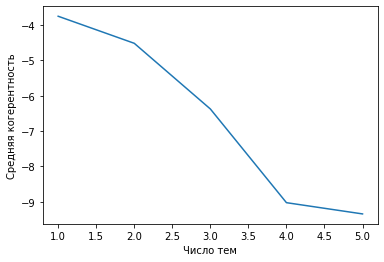

In [36]:
topics_list = [1, 2, 3, 4, 5]
coherences = []

for num in tqdm(topics_list):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, corpus=corpus, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()